based on: https://github.com/essentialsofparallelcomputing/Chapter3/blob/master/JupyterNotebook/HardwarePlatformCharaterization.ipynb

## Operator Benchmark on Gauss3

### Empirically Determined Parameters

based on `src_master_thesis/node_characterization/likwid-bench_gauss3.out`:

In [11]:
emp_flops_max=2459.32383
emp_mem_band=233.172

### Benchmark data

In [12]:
import csv

def read_Results(p_path):
    results = {
        'apply': [],
        'overall': []
    }
    with open(p_path, 'r') as f:
        reader = csv.reader(f)
        #
        # NOTE skip the header
        #
        next(reader, None)
        for row in reader:
            performance = float(row[9])
            memory_bandwidth = float(row[10])
            result = {
                    #
                    # NOTE MFLOP/s => GFLOP/s
                    #
                    'flops': performance/1000,
                    'ai': performance/memory_bandwidth,
                    'label': row[2]
                }
            results[row[3]].append(result)
    return results

In [13]:
FLOPS_apply = []
FLOPS_overall = []
AI_apply = []
AI_overall = []
LABEL_apply = []
LABEL_overall = []

results = read_Results('./e_roofline.csv')

display(results)

for result in results['apply']:
    FLOPS_apply.append(result['flops'])
    AI_apply.append(result['ai'])
    LABEL_apply.append(result['label'])
for result in results['overall']:
    FLOPS_overall.append(result['flops'])
    AI_overall.append(result['ai'])
    LABEL_overall.append(result['label'])

{'apply': [{'flops': 1.2336875,
   'ai': 0.26145126056833173,
   'label': '\\Verb{unoptimized}'},
  {'flops': 4.7716505,
   'ai': 0.22790192847046312,
   'label': '\\Verb{compiler_optimized}'},
  {'flops': 6.6766681,
   'ai': 0.22683561329689014,
   'label': '\\Verb{auto_vectorization}'},
  {'flops': 6.5912099,
   'ai': 0.2250186995816356,
   'label': '\\Verb{vcl_vectorization}'}],
 'overall': []}

### Roofline Model

In [14]:
roofline_flops=emp_flops_max
roofline_mem_band=emp_mem_band
roofline_ma_bal=roofline_flops/roofline_mem_band

OrderedDict([('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'), ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf')])


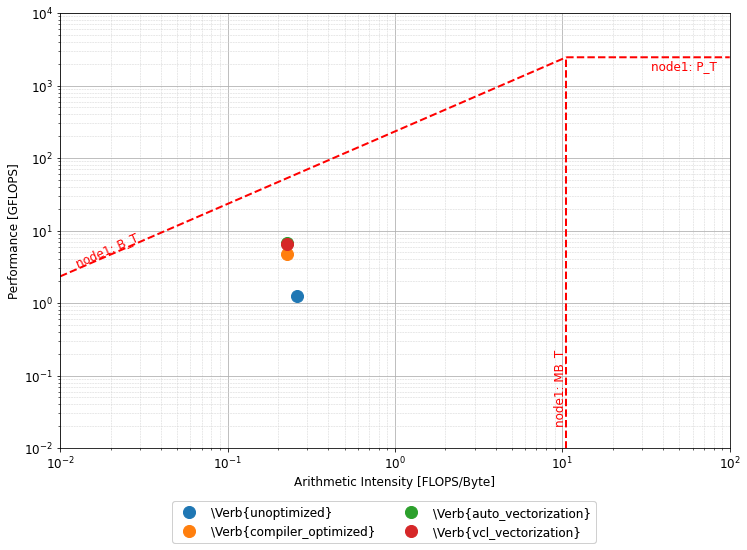

In [15]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install numpy

# %matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

print(mcolors.TABLEAU_COLORS)

font = {'size': 12}
plt.rc('font', **font)
matplotlib.rcParams['svg.fonttype'] = 'none'
fig = plt.figure(1,figsize=(12,8))

markersize = 12
colors = list(mcolors.TABLEAU_COLORS.values())
styles = ["o", "^"]

plt.clf()
ax = fig.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Arithmetic Intensity [FLOPS/Byte]')
ax.set_ylabel('Performance [GFLOPS]')
ax.grid()
ax.grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')

nx = 10000
xmin = -2
xmax = 2
ymin = 0.01
ymax = 10000

roofline_color = 'r'

ax.set_xlim(10**xmin, 10**xmax)
ax.set_ylim(ymin, ymax)

ixx = int(nx*0.02)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

scomp_x_elbow = [] 
scomp_ix_elbow = [] 
smem_x_elbow = [] 
smem_ix_elbow = [] 

x = np.logspace(xmin,xmax,nx)

#
# rooflines
#
for ix in range(1,nx):
    if roofline_mem_band * x[ix] >= roofline_flops and roofline_mem_band * x[ix-1] < roofline_flops:
        theoMem_ix_elbow = ix-1
        break
for ix in range(1,nx):
    if (roofline_flops <= roofline_mem_band * x[ix] and roofline_flops > roofline_mem_band * x[ix-1]):
        theoFlops_ix_elbow = ix-1
        break
y = np.ones(len(x)) * roofline_flops
ax.plot(x[theoFlops_ix_elbow:],y[theoFlops_ix_elbow:],c=roofline_color,ls='--',lw='2')
ax.text(x[-ixx],roofline_flops*0.95,
    'node1: P_T',
    horizontalalignment='right',
    verticalalignment='top',
    c=roofline_color)
y = x * roofline_mem_band  
ax.plot(x[:theoMem_ix_elbow+1],y[:theoMem_ix_elbow+1],c=roofline_color,ls='--',lw='2')
ang = np.arctan(np.log10(xlim[1]/xlim[0]) / np.log10(ylim[1]/ylim[0]) 
    * fig.get_size_inches()[1]/fig.get_size_inches()[0] )
ax.text(x[ixx],x[ixx]*roofline_mem_band*(1+0.25*np.sin(ang)**2),
    'node1: B_T',
    horizontalalignment='left',
    verticalalignment='bottom',
    rotation=180/np.pi*ang,
    c=roofline_color)
plt.vlines(roofline_ma_bal, 0, roofline_flops, colors=roofline_color, linestyles='dashed', linewidth=2)
ax.text(roofline_ma_bal,2*ymin,
    'node1: MB_T',
    horizontalalignment='right',
    verticalalignment='bottom',
    rotation=90,
    c=roofline_color)

marker_handles = list()
for i in range(0,len(AI_apply)):
    l_marker = styles[0]
    if LABEL_apply[i] == 'vcl_vectorization':
        l_marker = styles[1]
    ax.plot(float(AI_apply[i]),float(FLOPS_apply[i]),c=colors[i],marker=l_marker,linestyle='None',ms=markersize,label=LABEL_apply[i])
    marker_handles.append(ax.plot([],[],c=colors[i],marker=l_marker,linestyle='None',ms=markersize,label=LABEL_apply[i])[0]) 

#
# NOTE: put legend out of the plot: https://stackoverflow.com/a/43439132
#
leg1 = plt.legend(handles = marker_handles,
                  ncol=2,
                  bbox_to_anchor=(0.5,-0.05),
                  bbox_transform=fig.transFigure,
                  loc="lower center")
ax.add_artist(leg1)

# plt.savefig('roofline.png')
# plt.savefig('roofline.eps')
# plt.savefig('roofline.pdf')
plt.savefig('roofline.svg')

plt.show()